In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geocube
from geocube.api.core import make_geocube

import xarray as xr
import time

from netCDF4 import Dataset

from shutil import copyfile
import netCDF4

directory = '/ocean/projects/ees210014p/xjliu/DATA/landuse/'

ERROR 1: PROJ: proj_create_from_database: Open of /ocean/projects/atm200007p/xjliu/miniconda3/envs/geocube_env/share/proj failed


In [2]:
### public lands
shapefile = 'Brando/FPND_2020.shp'  
PLgeol = gpd.read_file(directory+shapefile) # read into a GeoDataFrame
PLgeol[['OBJECTID', 'nome', 'orgao', 'classe', 'estagio', 'governo', 'codigo',
       'ano', 'uf', 'protecao', 'tipo', 'comunitari', 'atolegal', 'anocriacao',
       'categoria', 'observacao', 'sobreposic']].head() # which looks like this

### conservation units
shapefile = 'Brando/UCS_CNUC_MMA_2022.shp'
CUgeol = gpd.read_file(directory+shapefile) # read into a GeoDataFrame
CUgeol.head() # 
CUgeol = CUgeol.to_crs(PLgeol.geometry.crs) # change it into the same coordinates as Public lands

### indigenous land
shapefile = 'Brando/TI_FUNAI_2019.shp'
ILgeol = gpd.read_file(directory+shapefile) # read into a GeoDataFrame
ILgeol = ILgeol.to_crs(PLgeol.geometry.crs) # change it into the same coordinates as Public lands

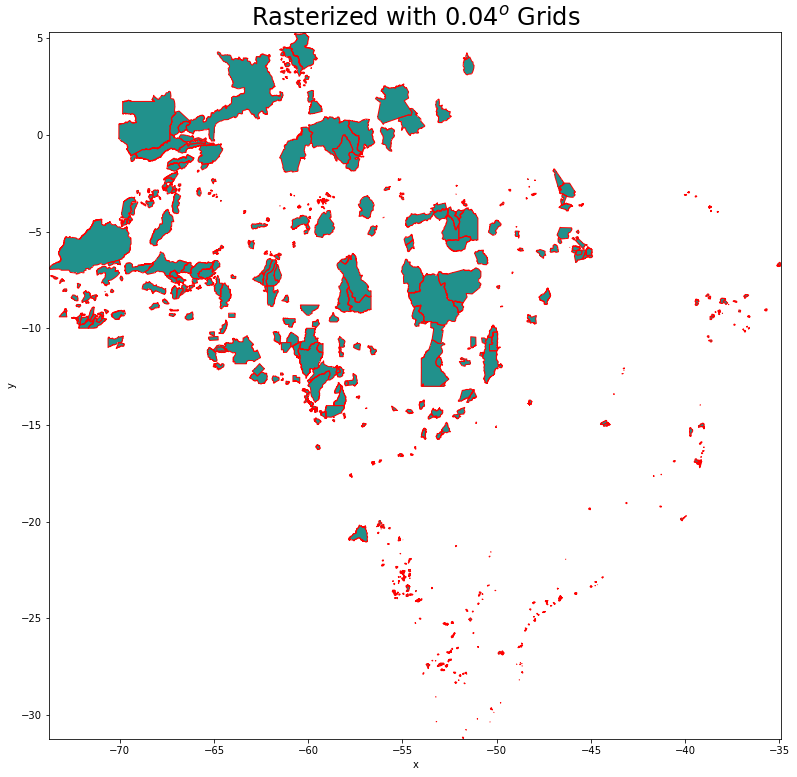

In [3]:
ILgeol['value']=1
IL_grid = geocube.api.core.make_geocube(ILgeol,resolution=(0.03932953, 0.04154205),measurements=['value'],fill=-9999)

da_grib = xr.where(IL_grid.value<-1999.0, np.nan, IL_grid.value)

fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(1, 1, 1)

da_grib.plot(ax=ax, add_colorbar=False)
ILgeol.plot(ax=ax, facecolor='None', edgecolor='r')

ax.set_title("Rasterized with 0.04$^o$ Grids", fontsize=24);

In [4]:
import netCDF4
import xarray as xr
filein='/jet/home/xjliu/Amazon_exp/test_CLM4/wrfinput_d01'
with xr.open_dataset(filein) as ds:
    print('ok')
    lats = ds['XLAT'][0,:,:]
    lons = ds['XLONG'][0,:,:]
    luindex =ds['LU_INDEX']


#ds = netCDF4.Dataset('wrfinput_d01', 'r+')
#lats = ds['XLAT'][0,:,:]
#lons = ds['XLONG'][0,:,:]
#luindex =ds['LU_INDEX']
##### Note, xr.where is different from ds.where or np.where. 
#ds['LU_INDEX'][:] = ds['LU_INDEX'].where(np.isnan(IL_sel)==True,12)
#ds['LU_INDEX'][:]=xr.where(np.isnan(IL_sel_3D)==False,12,ds['LU_INDEX']) # replace forest with cropland
#ds.to_netcdf(directory+'wrfinput_d01_ILdeforested.nc') # rewrite to netcdf

ok


In [5]:
### change soil moisture to be zero
filein='/jet/home/xjliu/Amazon_exp/test_soilMoist/wrfinput_d01'
fileout='/jet/home/xjliu/Amazon_exp/test_soilMoist/wrfinput_d01_noSMOIS'
copyfile(filein,fileout)
dset1 = netCDF4.Dataset(fileout, 'r+')
#lats = dset1['XLAT'][0,:,:]
#lons = dset1['XLONG'][0,:,:]
#luindex =dset1['LU_INDEX']

dset1['SMOIS'][:] = 0.0

dset1.close() # if you want to write the variable back to disk

In [5]:
### change soil moisture to be zero
filein='/jet/home/xjliu/Amazon_exp/test_soilMoist/wrfinput_d01'
fileout='/jet/home/xjliu/Amazon_exp/test_soilMoist_ILgrassland/wrfinput_d01_ILgrassland_noSMOIS'
copyfile(filein,fileout)
dset1 = netCDF4.Dataset(fileout, 'r+')
#lats = dset1['XLAT'][0,:,:]
#lons = dset1['XLONG'][0,:,:]
#luindex =dset1['LU_INDEX']

dset1['SMOIS'][:] = 0.0

### deforest
## change the da_grib of the corresponding domain of luindex
IL_sel = da_grib.sel(y=lats[:,0],x=lons[0,:],method='nearest')
IL_sel_3D = np.expand_dims(IL_sel,axis=0)

luindex_new = xr.where(IL_sel_3D==1,10,luindex)  # replace forest with cropland
luindex_new = xr.where(luindex==17,luindex,luindex_new)  # change the LUindex back to water (17) where it is water

dset1['LU_INDEX'][:] = luindex_new


dset1.close() # if you want to write the variable back to disk

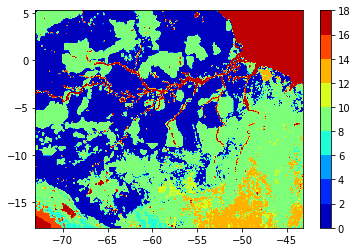

In [24]:
ds1 = netCDF4.Dataset(fileout,'r+')
luindex_de =ds1['LU_INDEX']
plt.contourf(lons,lats,luindex_de[0,:,:],cmap='jet')
plt.colorbar()

In [7]:
luindex_de[0,300,:100]

masked_array(data=[2., 2., 2., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
                   9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
                   9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
                   9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
                   9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
                   9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
                   9., 9., 9., 9., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                   2., 2.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [8]:
lu0[0,300,:100]

masked_array(data=[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                   2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                   2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                   2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                   2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                   2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                   2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
                   2., 2.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [22]:
plt.contourf(luindex_de[0,:,:]-lu0[0,:,:])

NameError: name 'lu0' is not defined